<p><center><h1>💶 Algorithme de détection automatique de faux billets</h1></center></p>
<p><center><h1>Partie 1 - Analyse</h1></center></p>

**ONCFM - Organisation nationale de lutte contre le faux-monnayage** est une organisation publique ayant pour objectif de mettre en place des méthodes d'identification des contrefaçons des billets en euros.
Dans le cadre de cette lutte, nous souhaitons mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets.

## Objectifs

Lorsqu'un billet arrive, nous avons une machine qui consigne l'ensemble de ses caractéristiques géométriques. Au fil de nos années de lutte, nous avons observé des différences de dimensions entre les vrais et les faux billets. Ces différences sont difficilement visibles à l'oeil nu, mais une machine devrait sans problème arriver à les différencier.

Ainsi, il faudrait construire un algorithme qui, à partir des caractéristiques géométriques d'un billet, serait capable de définir si ce dernier est un vrai ou un faux billet.

<img src="../gfx/sep.jpg" alt="Barre">

## Chargement

***

In [1]:
# Chargement des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.color_palette("viridis")
sns.set_theme(style="darkgrid")

from scipy import stats

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA

from adjustText import adjust_text

In [2]:
# Chargement des données
df = pd.read_csv("../data/billets.csv", sep=';')
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


<img src="../gfx/sep.jpg" alt="Barre">

## 1 - Analyse descriptive

***

### 1.1 - Description du jeu de données

Les données sont composées d'une variable cible : 
- **is_genuine**, détermine si le billet est vrai ou faux (true/false)

In [3]:
df['is_genuine'].value_counts()

is_genuine
True     1000
False     500
Name: count, dtype: int64

Le jeu de données est composé de 1500 billets, répartis de la sorte :
- 1000 vrais billets
- 500 faux billets

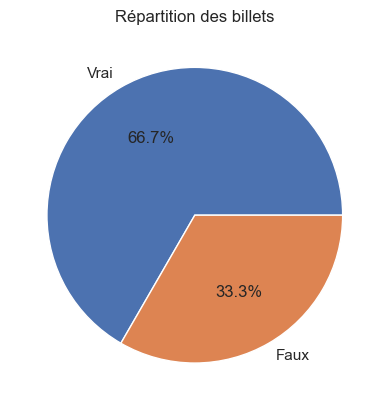

In [4]:
plt.pie(df['is_genuine'].value_counts(), labels=['Vrai', 'Faux'], autopct='%1.1f%%')
plt.title('Répartition des billets')
plt.show()

Les données comportent également 6 variables predictifs, correspondant aux dimensions géométriques des billets :
- **diagonal**, la diagonal du billet (en mm)
- **height_left**, la hauteur du billet mesurée sur le côté gauche (en mm)
- **height_right**, la hauteur du billet mesurée sur le côté droit (en mm)
- **margin_low**, la marge entre le bord inférieur du billet et l'image de celui-ci (en mm)
- **margin_up**, la marge entre le bord supérieur du billet et l'image de celui-ci (en mm)
- **length**, la longueur du billet (en mm)

In [5]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [6]:
# Récupération du dataframe ne comportant que des variables numériques
df_num = df.select_dtypes(include='number')
indicateurs = df_num.columns

### 1.2 - Valeurs manquantes

In [7]:
# Vérification des valeurs manquantes
df.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

> Seule la dimension **margin_low** comporte des valeurs manquantes.

> Il nous faut inférer ces valeurs manquantes à l'aide d'une ***régression linéaire*** à partir des autres variables.

In [8]:
# Copie du dataframe sans les manquants de margin_low
df_ml = df.copy()
df_ml.dropna(subset=['margin_low'], inplace=True)
# Copie du dataframe avec seulement les manquants de margin_low
df_mlna = df.copy()
df_mlna = df_mlna[df_mlna['margin_low'].isna()]

# Vérification des valeurs manquantes
df_ml.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [9]:
# Conversion de la variable is_genuine en variable binaire
df_ml['is_genuine'] = df_ml['is_genuine'].astype('int')
df_ml['is_genuine'].value_counts()

is_genuine
1    971
0    492
Name: count, dtype: int64

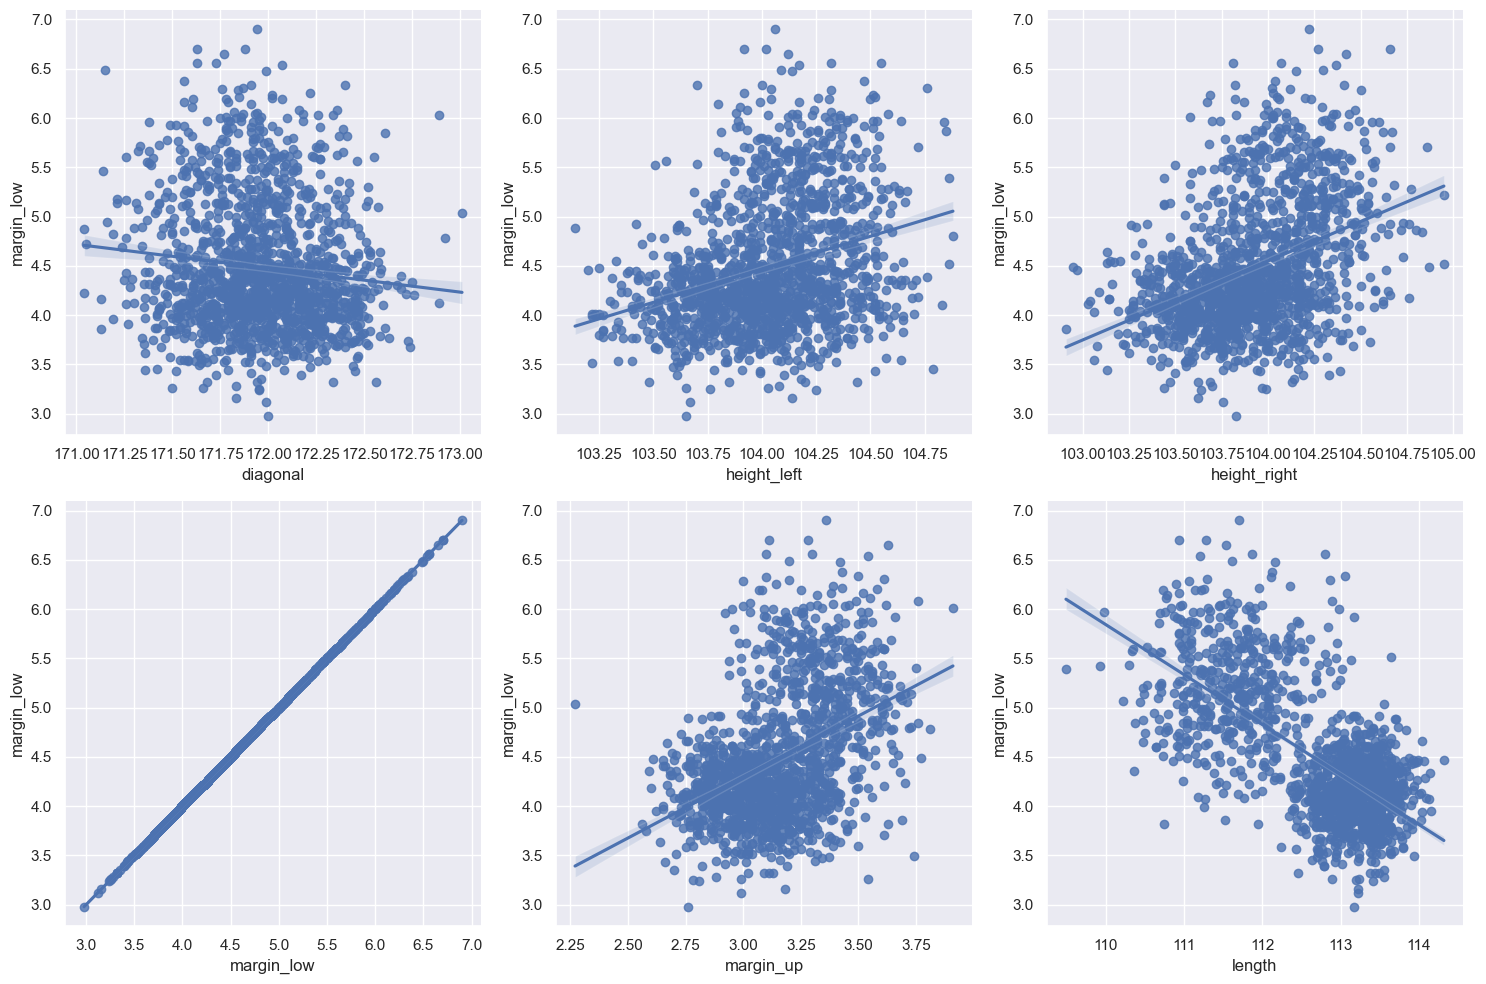

In [10]:
# Analyse bivariée
fig, ax = plt.subplots(2, 3, figsize=(15,10))

for i in range(2):
    for j in range(3):
        sns.regplot(x=df_ml[indicateurs[3*i+j]], y=df_ml['margin_low'], ax=ax[i,j])
        plt.ylabel('margin_low')
        plt.xlabel(indicateurs[3*i+j])
        plt.grid()
        sns.despine()
    
plt.tight_layout()
plt.show()

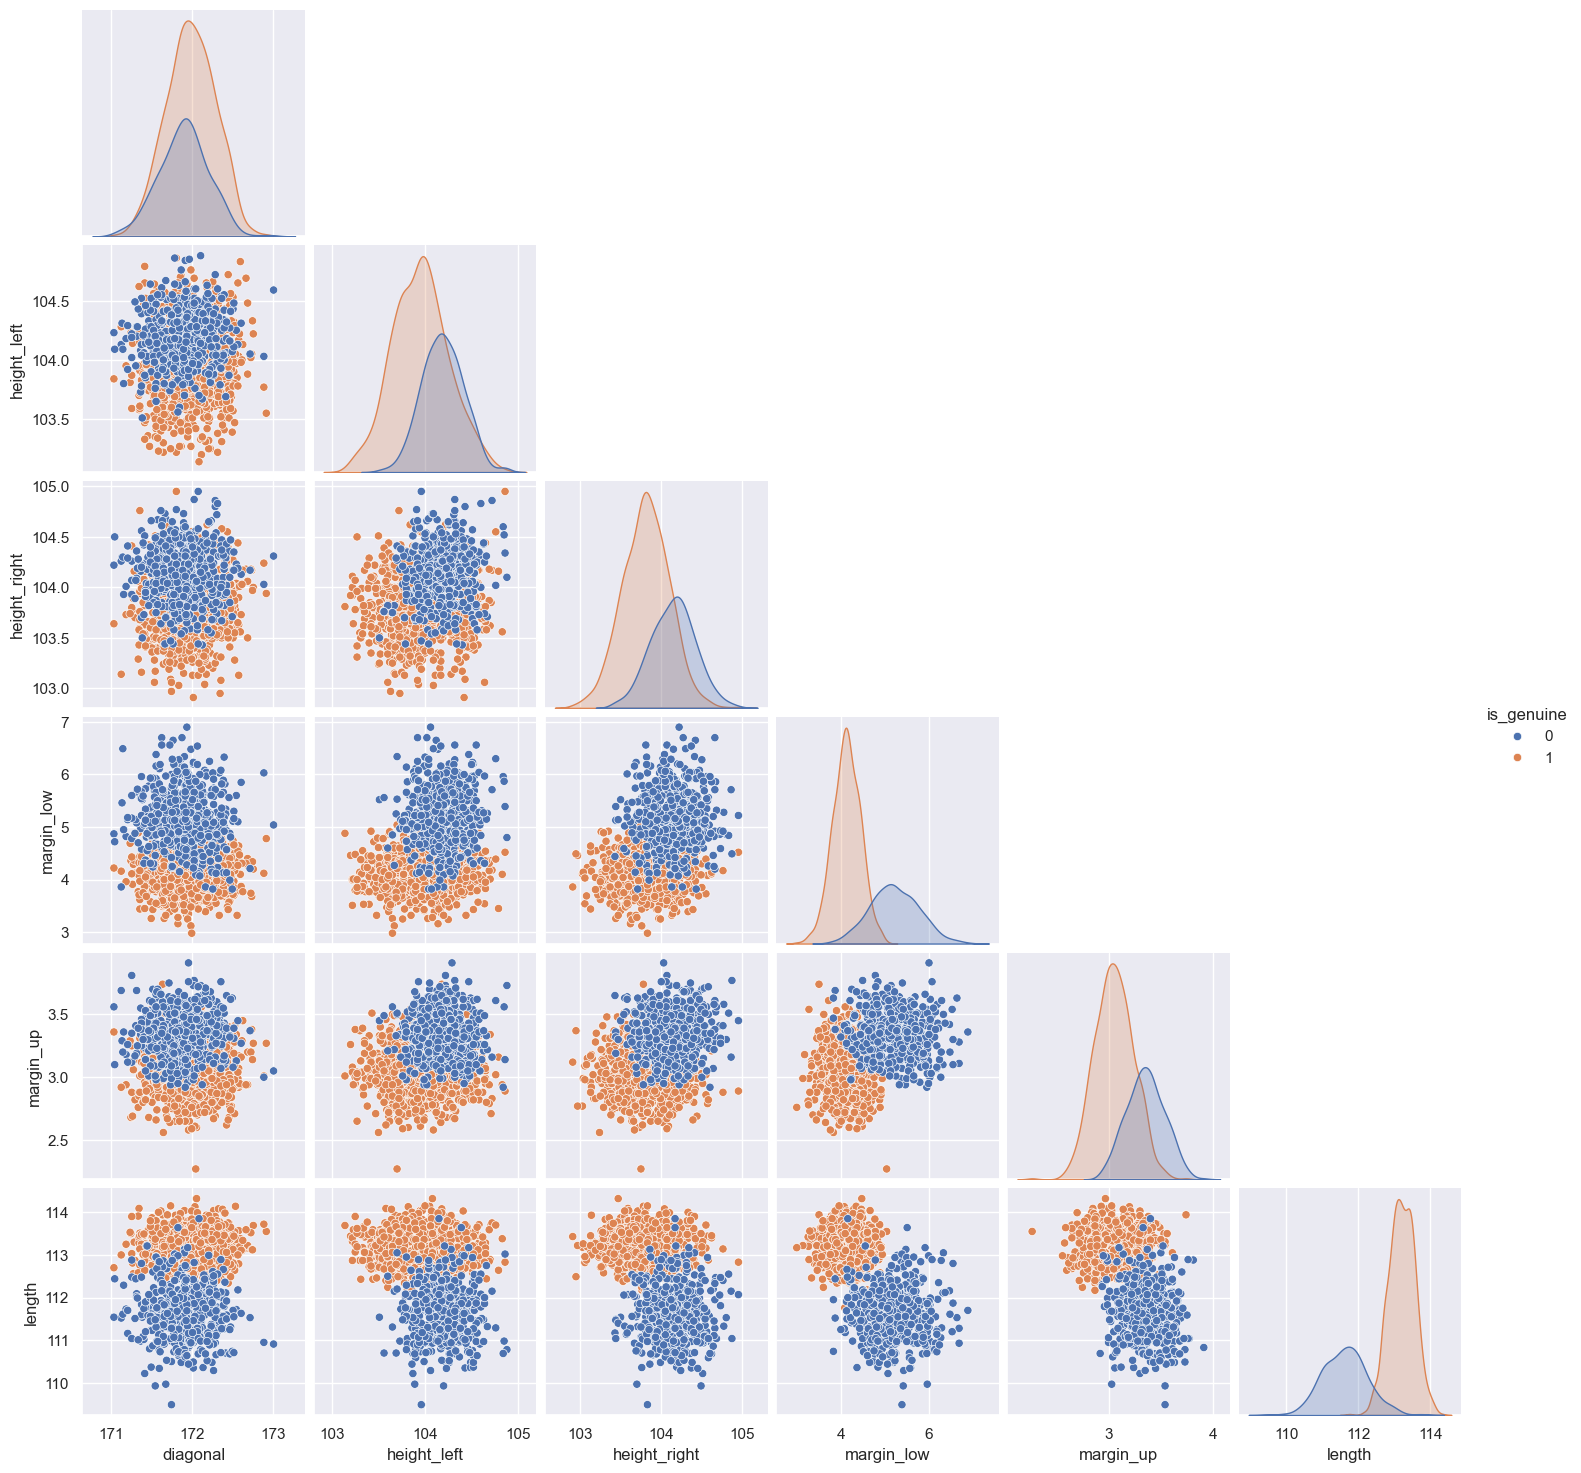

In [11]:
# Distributions croisées
sns.pairplot(df_ml, hue='is_genuine', corner=True)
plt.show()

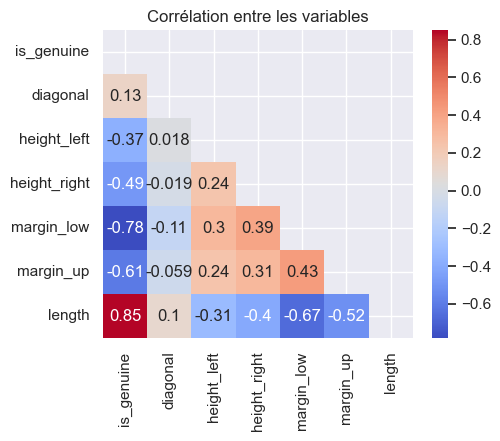

In [12]:
# Analyse des corrélations
correlation = df_ml.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
plt.figure(figsize=(5,4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', mask=mask)
plt.title('Corrélation entre les variables')
plt.show()

In [13]:
varpred = ['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_up', 'length']

# Régression linéaire
reg = LinearRegression()
X = df_ml[varpred]
y = df_ml['margin_low']
reg.fit(X,y)

LinearRegression()

In [14]:
print(f"R^2 : {np.round(reg.score(X,y), 3)}")
print(f"margin_low = {np.round(reg.coef_[0], 2)} * is_genuine + {np.round(reg.coef_[1], 2)} * diagonal + {np.round(reg.coef_[2], 2)} * height_left + {np.round(reg.coef_[3], 2)} * height_right + {np.round(reg.coef_[4], 2)} * margin_up + {np.round(reg.coef_[5], 2)} * length + bruit")

R^2 : 0.617
margin_low = -1.14 * is_genuine + -0.01 * diagonal + 0.03 * height_left + 0.03 * height_right + -0.21 * margin_up + -0.0 * length + bruit


In [15]:
# Prédictions
y_pred = reg.predict(X)
print(f"MSE : {np.round(mean_squared_error(y, y_pred), 2)}")
print(f"MAPE : {np.round(mean_absolute_percentage_error(y, y_pred), 2)}")

MSE : 0.17
MAPE : 0.07


In [16]:
# Utilisation d'un scaler pour contraindre les variables entre 0 et 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_ml[varpred])
df_ml_scaled = pd.DataFrame(X_scaled, columns=varpred)
df_ml_scaled.describe().loc[['min', 'max']]

,is_genuine,diagonal,height_left,height_right,margin_up,length
min,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0


In [17]:
# Scinder les données en jeu d'entraînement et de test
X = df_ml_scaled[varpred]
y = df_ml['margin_low']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Entraînement du modèle
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [19]:
# Prédiction sur le test set
y_pred_test = reg.predict(X_test)

# Scores
print(f"RMSE: {mean_squared_error(y_test, y_pred_test)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred_test)}")

RMSE: 0.13739452871780827
MAPE: 0.06496074172211527


> On a un très bon modèle.

In [20]:
# Inférence des manquants de margin_low
X_mlna_scaled = scaler.fit_transform(df_mlna[varpred])
df_mlna_scaled = pd.DataFrame(X_mlna_scaled, columns=varpred)
y_mlna_pred = reg.predict(df_mlna_scaled)
df_mlna['margin_low'] = np.round(y_mlna_pred, 2)

In [21]:
# Concaténation des dataframes pour obtenir un dataframe sans manquants
df = pd.concat([df_ml, df_mlna], axis=0)
df_num = df.select_dtypes(include='number')

In [22]:
# Vérification des valeurs manquantes
df.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [23]:
df.describe()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,0.666667,171.958440,104.029533,103.920307,4.482913,3.151473,112.67850
std,0.471562,0.305195,0.299462,0.325627,0.659696,0.231813,0.87273
min,0.000000,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,0.000000,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000
50%,1.000000,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,1.000000,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,1.000000,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


> Les valeurs pour margin_low sont très proches des valeurs d'avant la régression linéaire.

### 1.3 - Valeurs aberrantes ou atypiques

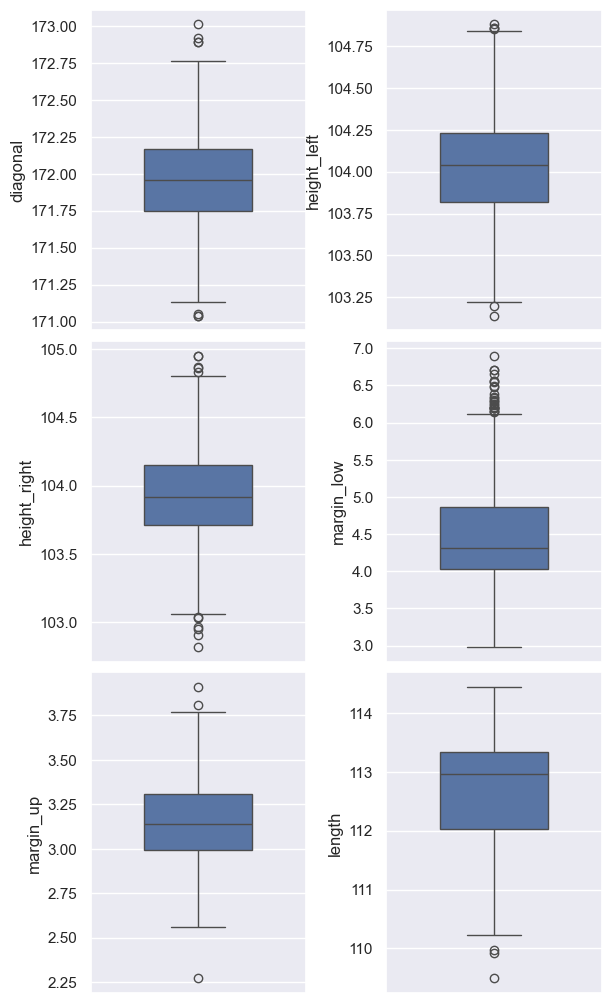

In [24]:
# Répartition des dimensions des billets
ind_j = 2
ind_i = int(len(indicateurs)/ind_j)
fig, ax = plt.subplots(ind_i, ind_j, figsize=(6,10))

for i in range(ind_i):
    for j in range(ind_j):
        sns.boxplot(data=df_num[indicateurs[ind_j*i+j]], ax=ax[i,j], width=0.5)

fig.tight_layout(pad=0.5)
plt.show()

In [25]:
# Copie du dataframe pour vérification par stats
df_stats = df_num.copy()
z_indicateurs = ['z_diagonal', 'z_height_left', 'z_height_right', 'z_margin_low', 'z_margin_up', 'z_length']

# Vérification avec le Z-Score
df_stats['z_diagonal'] = stats.zscore(df_stats.diagonal)
df_stats['z_height_left'] = stats.zscore(df_stats.height_left)
df_stats['z_height_right'] = stats.zscore(df_stats.height_right)
df_stats['z_margin_low'] = stats.zscore(df_stats.margin_low)
df_stats['z_margin_up'] = stats.zscore(df_stats.margin_up)
df_stats['z_length'] = stats.zscore(df_stats.length)

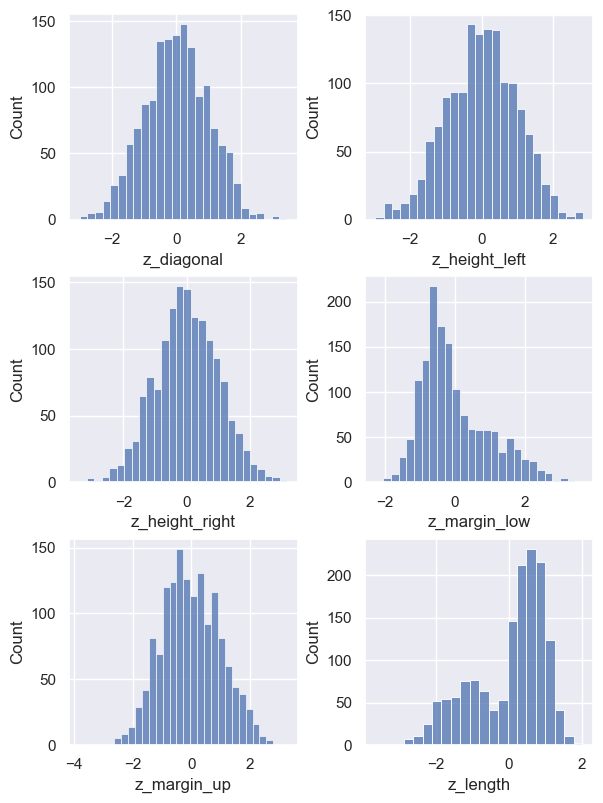

In [26]:
# Histogramme des Z-Scores
fig, ax = plt.subplots(ind_i, ind_j, figsize=(6,8))

for i in range(ind_i):
    for j in range(ind_j):
        sns.histplot(data=df_stats[z_indicateurs[ind_j*i+j]], ax=ax[i,j])

fig.tight_layout(pad=0.5)
plt.show()

> Les données dimensionnelles ne comportent ***pas de valeurs aberrantes ou atypiques***.

### 1.4 - Résumé du jeu de données

In [27]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int64  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 93.8 KB


> 1500 échantillons

> 1 variable cible binaire (0 : faux billet, 1 : vrai billet)

> 6 variables prédictives

<img src="../gfx/sep.jpg" alt="Barre">

## 2 - Régression Logistique

***

In [28]:
X = df_num[indicateurs]
y = df_num['is_genuine']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Régression logistique
clf = LogisticRegression(random_state=808).fit(X_train, y_train)

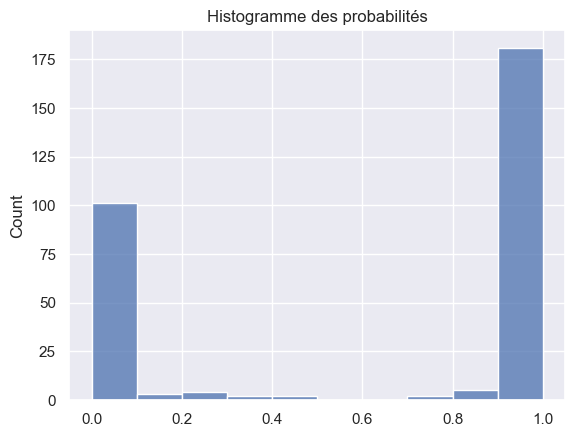

In [30]:
# Histogramme des probabilités pour analyser les performances du modèle
y_hat_proba = clf.predict_proba(X_test)[:,1]
sns.histplot(y_hat_proba)
plt.title('Histogramme des probabilités')
plt.show()

> Modèle assez fiable sur ses prédictions, la plupart des prédictions ont une probabilité proche de 0 ou de 1.

In [31]:
# Accuracy
y_pred = clf.predict(X_test)
print(f"Accuracy : {accuracy_score(y_test, y_pred)}")

Accuracy : 0.99


> Nous obtenons un très bon score pour cette régression logistique avec ***99% d'exactitude***.

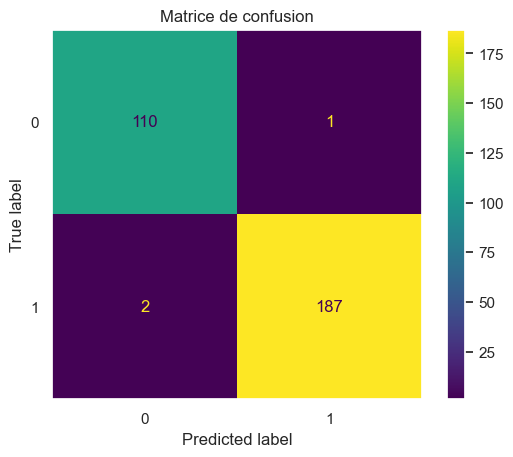

In [32]:
# Nous vérifions si le modèle est biaisé à l'aide d'une matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.grid(None)
plt.title('Matrice de confusion')
plt.show()

> Le modèle ne comporte pas de biais.

In [33]:
# Precision et Recall
print(f"Precision : {precision_score(y_test, y_pred)}")
print(f"Recall : {recall_score(y_test, y_pred)}")
print(f"ROC-AUC : {roc_auc_score(y_test, y_hat_proba)}")

Precision : 0.9946808510638298
Recall : 0.9894179894179894
ROC-AUC : 0.9997616664283331


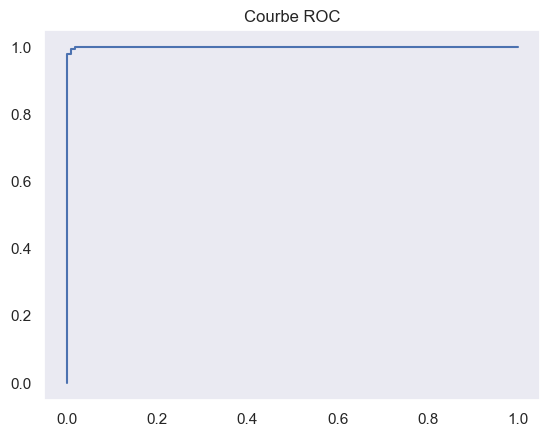

In [34]:
# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_hat_proba)

plt.plot(fpr, tpr)
plt.grid()
plt.title('Courbe ROC')
plt.show()

> Cette Régression Logistique est un excellent modèle.

<img src="../gfx/sep.jpg" alt="Barre">

## 3 - K-Means

***

In [35]:
# Centrage et réduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

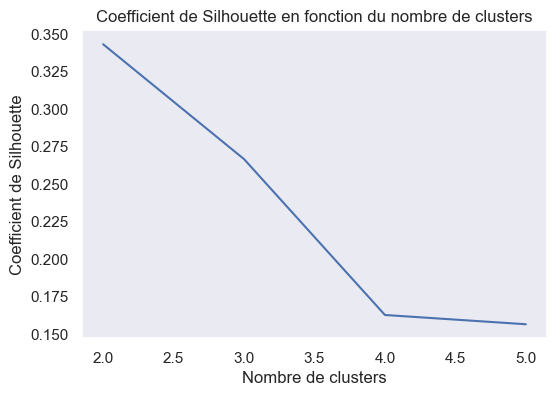

In [36]:
# Nombre optimal de clusters avec le coefficient de silhouette
silhouette_scores = []
for n_clusters in range(2, 6):
    kms = KMeans(init="k-means++", n_clusters=n_clusters, random_state=808, n_init='auto')
    kms.fit(X_scaled)
    kms_labels = kms.predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, kms_labels))

fig, ax = plt.subplots(figsize=(6,4))
plt.plot(range(2, 6), silhouette_scores)
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de Silhouette')
plt.title('Coefficient de Silhouette en fonction du nombre de clusters')
plt.grid()
plt.show()

> Nous avons un pic du coefficient de Silhouette pour ***2 clusters***.

In [37]:
# Nombre de clusters optimal
k = 2

In [38]:
kmeans = KMeans(n_clusters=k, random_state=808, n_init='auto')
kmeans.fit(X_scaled)

print(f"Score : {kmeans.score(X_scaled)}")
print(f"Silhouette Score : {silhouette_score(X_scaled, kmeans.labels_)}")

Score : -5802.2531779268065
Silhouette Score : 0.3432401155486946


In [39]:
y_pred = kmeans.labels_
y_real = df['is_genuine']

# Accuracy
print(f"Accuracy : {accuracy_score(y_real, y_pred)}")

Accuracy : 0.9846666666666667


> KMeans est moins performant que la Régression Logistique

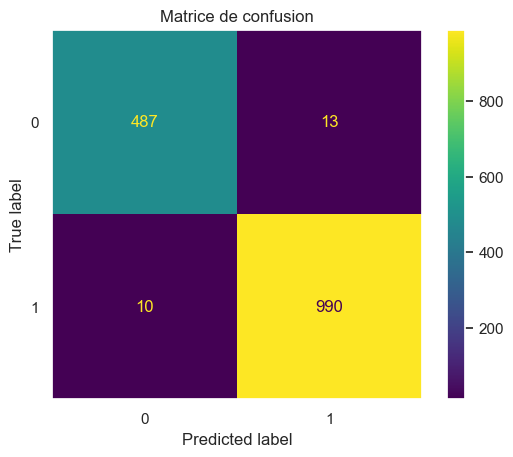

In [40]:
# Matrice de confusion
cm = confusion_matrix(y_real, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(None)
plt.title('Matrice de confusion')
plt.show()

In [41]:
# Precision et Recall
print(f"Precision : {precision_score(y_real, y_pred)}")
print(f"Recall : {recall_score(y_real, y_pred)}")

Precision : 0.9870388833499502
Recall : 0.99


<img src="../gfx/sep.jpg" alt="Barre">

## 4 - K-Nearest Neighbors

***

In [42]:
# Séparation du jeu de données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Centrage et réduction
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [44]:
# Classifieur KNN
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train_scaled, y_train)
# Prédiction
y_pred = clf.predict(X_test_scaled)

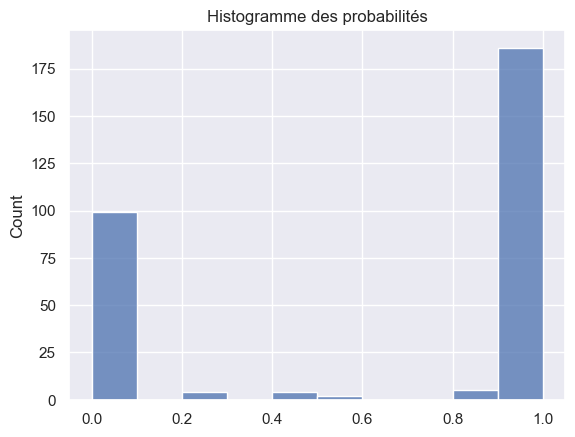

In [45]:
# Histogramme des probabilités pour analyser les performances du modèle
y_hat_proba = clf.predict_proba(X_test_scaled)[:,1]
sns.histplot(y_hat_proba)
plt.title('Histogramme des probabilités')
plt.show()

> Modèle assez fiable sur ses prédictions, la plupart des prédictions ont une probabilité proche de 0 ou de 1.

In [46]:
# Accuracy
y_pred = clf.predict(X_test_scaled)
print(f"Accuracy : {accuracy_score(y_test, y_pred)}")

Accuracy : 0.9866666666666667


> Nous obtenons un très bon score pour cette régression logistique avec ***98,6% d'exactitude***.

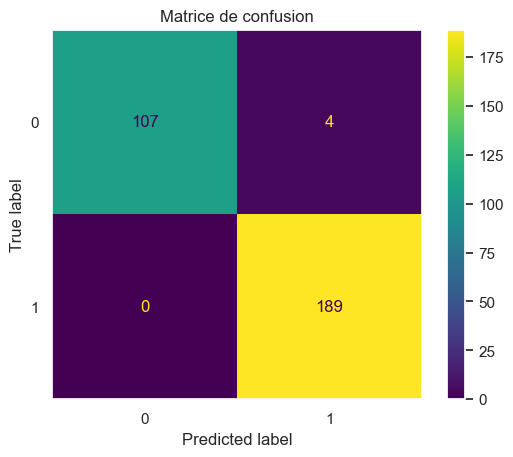

In [47]:
# Nous vérifions si le modèle est biaisé à l'aide d'une matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.grid(None)
plt.title('Matrice de confusion')
plt.show()

> Le modèle ne comporte pas de biais.

In [48]:
# Precision et Recall
print(f"Precision : {precision_score(y_test, y_pred)}")
print(f"Recall : {recall_score(y_test, y_pred)}")
print(f"ROC-AUC : {roc_auc_score(y_test, y_hat_proba)}")

Precision : 0.9792746113989638
Recall : 1.0
ROC-AUC : 0.9951379951379952


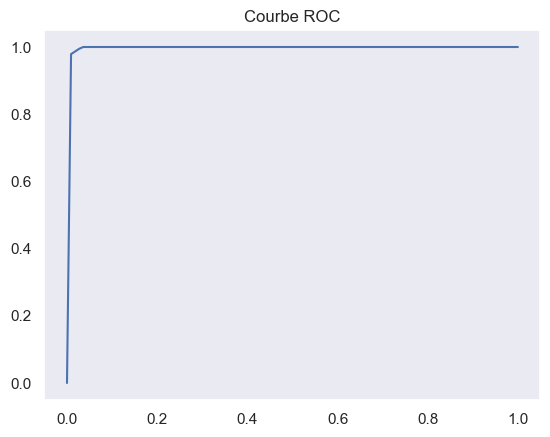

In [49]:
# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_hat_proba)

plt.plot(fpr, tpr)
plt.grid()
plt.title('Courbe ROC')
plt.show()

> Ce KNN est un excellent modèle.

<img src="../gfx/sep.jpg" alt="Barre">

## 5 - Random Forest

***

In [50]:
# Séparation du jeu de données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Classifieur Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=808)
# Entraînement du modèle
clf.fit(X_train, y_train)
# Prédiction sur le jeu de test
y_pred = clf.predict(X_test)

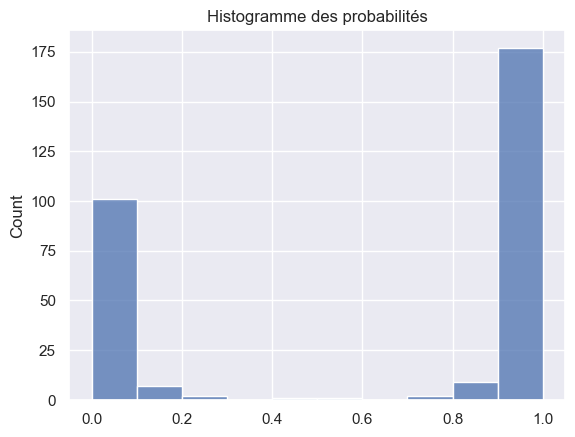

In [52]:
# Histogramme des probabilités pour analyser les performances du modèle
y_hat_proba = clf.predict_proba(X_test)[:,1]
sns.histplot(y_hat_proba)
plt.title('Histogramme des probabilités')
plt.show()

> Modèle assez fiable sur ses prédictions, la plupart des prédictions ont une probabilité proche de 0 ou de 1.

In [53]:
# Accuracy
y_pred = clf.predict(X_test)
print(f"Accuracy : {accuracy_score(y_test, y_pred)}")

Accuracy : 0.9933333333333333


> Nous obtenons un très bon score pour cette régression logistique avec ***99,3% d'exactitude***.

> Le meilleur score d'accuracy.

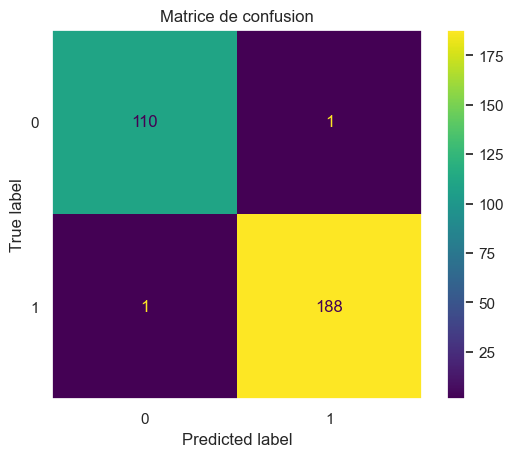

In [54]:
# Nous vérifions si le modèle est biaisé à l'aide d'une matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.grid(None)
plt.title('Matrice de confusion')
plt.show()

> Le modèle ne comporte pas de biais.

In [55]:
# Precision et Recall
print(f"Precision : {precision_score(y_test, y_pred)}")
print(f"Recall : {recall_score(y_test, y_pred)}")
print(f"ROC-AUC : {roc_auc_score(y_test, y_hat_proba)}")

Precision : 0.9947089947089947
Recall : 0.9947089947089947
ROC-AUC : 0.9998093331426665


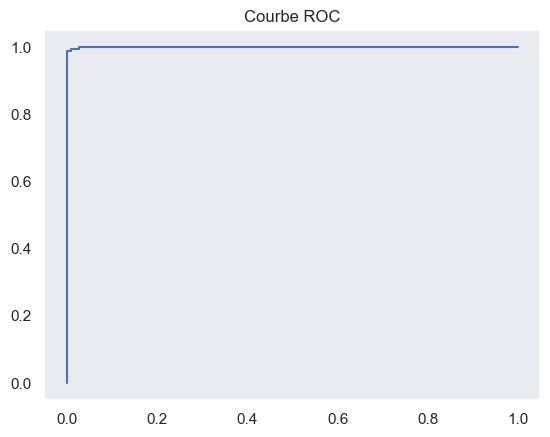

In [56]:
# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_hat_proba)

plt.plot(fpr, tpr)
plt.grid()
plt.title('Courbe ROC')
plt.show()

> Ce classifieur Random Forest est un excellent modèle.

<img src="../gfx/sep.jpg" alt="Barre">

## 2 - Analyse en composantes principales

***

In [57]:
# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [58]:
# Appliquer l'ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [59]:
# Proportion de la variance expliquée
scree = np.round(pca.explained_variance_ratio_*100, 1)
# Cumul de la variance expliquée
cum_scree = np.cumsum(scree)
# Valeurs corrigées
eigval = (pca.n_components_ - 1)/pca.n_components_ * pca.explained_variance_
# Liste des composantes
composantes = ['PC' + str(x) for x in range(1, len(scree)+1)]


In [60]:
comp = pd.DataFrame(
    {
        'Dimensions' : composantes,
        'Valeurs Propres' : pca.explained_variance_,
        'Valeurs Propres corrigées' : eigval,
        'Variance Expliquée (%)' : scree,
        'Cumul Variance Expliquée (%)' : cum_scree
    },
    columns=['Dimensions', 'Valeurs Propres', 'Valeurs Propres corrigées', 'Variance Expliquée (%)', 'Cumul Variance Expliquée (%)']
)
comp

,Dimensions,Valeurs Propres,Valeurs Propres corrigées,Variance Expliquée (%),Cumul Variance Expliquée (%)
0,PC1,2.593482,2.161235,43.2,43.2
1,PC2,1.018108,0.848423,17.0,60.2
2,PC3,0.781687,0.651406,13.0,73.2
3,PC4,0.709918,0.591599,11.8,85.0
4,PC5,0.580959,0.484132,9.7,94.7
5,PC6,0.319848,0.266540,5.3,100.0


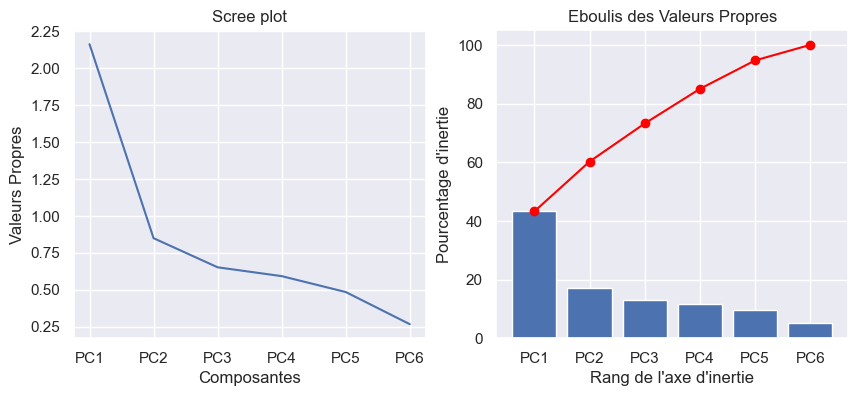

In [61]:
# Scree plot et Eboulis des Valeurs Propres
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(composantes, eigval)
ax1.set_title('Scree plot')
ax1.set_xlabel('Composantes')
ax1.set_ylabel('Valeurs Propres')

ax2.bar(composantes, scree)
ax2.plot(composantes, cum_scree, c='red', marker='o')
ax2.set_title('Eboulis des Valeurs Propres')
ax2.set_xlabel("Rang de l'axe d'inertie")
ax2.set_ylabel("Pourcentage d'inertie")

plt.show()

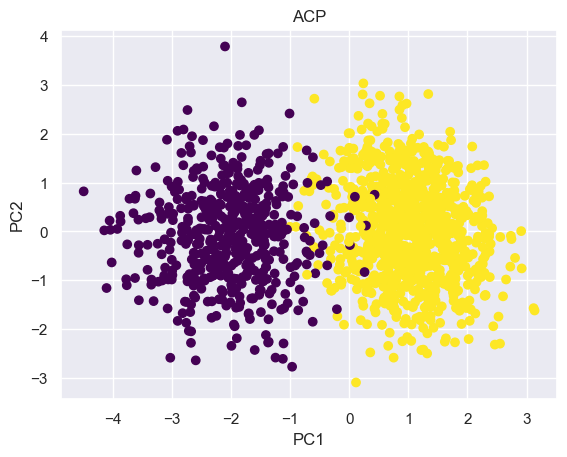

In [62]:
# Visualisation des données projetées
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('ACP')
plt.show()

In [63]:
# ACP à 2 composantes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [64]:
# Contribution des variables
cos_squared = np.round(np.square(pca.components_), 4)
contrib = pd.DataFrame(cos_squared, columns=indicateurs, index=['PC1', 'PC2'])
contrib

,diagonal,height_left,height_right,margin_low,margin_up,length
PC1,0.0072,0.1098,0.1551,0.2565,0.1929,0.2784
PC2,0.8861,0.0944,0.0118,0.0054,0.0000,0.0024


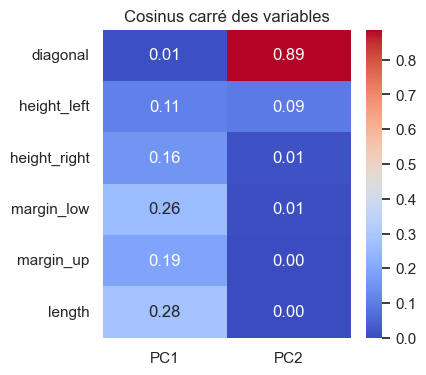

In [65]:
# Heatmap des cosinus carré
plt.figure(figsize=(4,4))
sns.heatmap(contrib.T, annot=True, cmap='coolwarm', fmt="0.2f")
plt.title('Cosinus carré des variables')
plt.show()

In [66]:
# Cercle des corrélations
def correlation_graph(pca,
                      x_y,
                      features):
    """Affiche le cercle des corrélations
    Arguments:
    ----------
    pca : sklearn.decomposition.PCA, notre objet PCA qui a été fit
    x_y : list ou tuple, le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple, la liste des features à représenter
    """

    # Extrait x et y
    x,y = x_y

    # Taille de l'image
    fig, ax = plt.subplots(figsize=(8, 7))

    # Etiquettes
    labels = []

    # Pour chaque composante
    for i in range(0, pca.components_.shape[1]):

        # Affichage des flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02)
        
        # Affichage des noms de variables
        labels.append(plt.text(pca.components_[x, i] + 0.05,
             pca.components_[y, i] + 0.05,
             features[i], horizontalalignment='center'))

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # Titre du graphique
    plt.title("Cercle des corrélations (F{} et F{}, {}%)".format(x+1, y+1, round(100*(pca.explained_variance_ratio_[x]+pca.explained_variance_ratio_[y]),1)))

    # Cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))

    adjust_text(labels, arrowprops=dict(arrowstyle="->", color='r', lw=1))

    # Axes et affichage
    plt.axis('equal')
    plt.show(block=False)

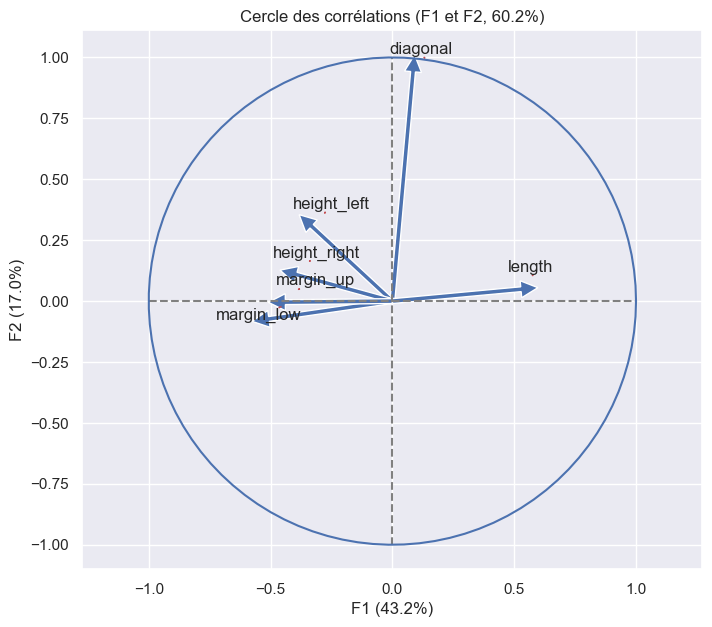

In [67]:
correlation_graph(pca, [0,1], indicateurs)

<img src="../gfx/sep.jpg" alt="Barre">

## 3 - Modèles de classification

***

### 3.1 - Division des données

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### 3.2 - Régression Logistique

In [69]:
# Instancation et entraînement du modèle
reglog = LogisticRegression(random_state=808).fit(X_train, y_train)

In [70]:
# Prédiction
reglog_y_pred = reglog.predict(X_test)

### 3.3 - K-Means

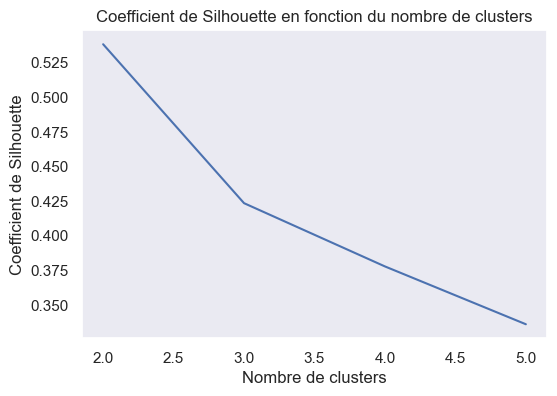

In [71]:
# Nombre optimal de clusters avec le coefficient de silhouette
silhouette_scores = []
for n_clusters in range(2, 6):
    kms = KMeans(init="k-means++", n_clusters=n_clusters, random_state=808, n_init='auto')
    kms.fit(X_pca)
    kms_labels = kms.predict(X_pca)
    silhouette_scores.append(silhouette_score(X_pca, kms_labels))

fig, ax = plt.subplots(figsize=(6,4))
plt.plot(range(2, 6), silhouette_scores)
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de Silhouette')
plt.title('Coefficient de Silhouette en fonction du nombre de clusters')
plt.grid()
plt.show()

> Nous avons un pic du coefficient de Silhouette pour ***2 clusters***.

In [72]:
# Nombre de clusters optimal
k = 2

In [73]:
kmeans = KMeans(n_clusters=k, random_state=808, n_init='auto')
kmeans.fit(X_pca)

print(f"Score : {kmeans.score(X_pca)}")
print(f"Silhouette Score : {silhouette_score(X_pca, kmeans.labels_)}")

Score : -2241.3758017339146
Silhouette Score : 0.5383416980664572


### 3.4 - K-Nearest Neighbors

In [74]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)

### 3.5 - Random Forest

In [75]:
ranfor = RandomForestClassifier(n_estimators=100, random_state=808)
ranfor.fit(X_train, y_train)
ranfor_y_pred = ranfor.predict(X_test)

### 3.6 - Gradient Boosting

In [76]:
graboo = GradientBoostingClassifier(n_estimators=100, random_state=808)
graboo.fit(X_train, y_train)
graboo_y_pred = graboo.predict(X_test)

<img src="../gfx/sep.jpg" alt="Barre">

## 4 - Evaluation des modèles

***

In [77]:
modeles = ['Régression Logistique', 'K-Means', 'K-Nearest Neighbors', 'Random Forest', 'Gradient Boosting']
modelessupervises = ['Régression Logistique', 'K-Nearest Neighbors', 'Random Forest', 'Gradient Boosting']
predictions = [reglog_y_pred, kmeans.labels_, knn_y_pred, ranfor_y_pred, graboo_y_pred]
y_refs = [y_test, y, y_test, y_test, y_test]

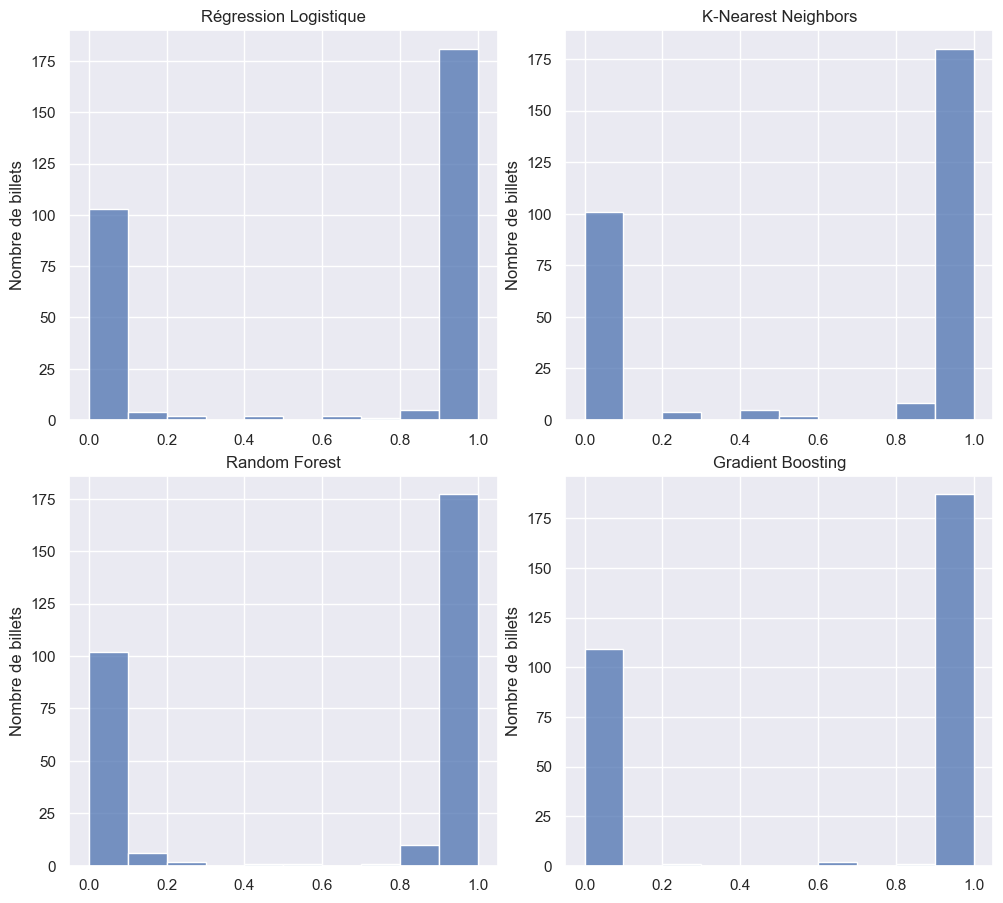

In [78]:
# Histogramme des probabilités
y_hat_probas = [reglog.predict_proba(X_test)[:,1], knn.predict_proba(X_test)[:,1], ranfor.predict_proba(X_test)[:,1], graboo.predict_proba(X_test)[:,1]]

fig, ax = plt.subplots(2, 2, figsize=(10,9))

for i in range(2):
    for j in range(2):
        sns.histplot(y_hat_probas[2*i+j], ax=ax[i,j])
        ax[i,j].set_title(modelessupervises[2*i+j])
        ax[i,j].set_ylabel('Nombre de billets')

fig.tight_layout(pad=0.5)
plt.show()

In [79]:
# Métriques
acc, cms, prec, rec = ([] for i in range(4))

for pred, ref in zip(predictions, y_refs):
    acc.append(accuracy_score(ref, pred))   # Accuracy
    cms.append(confusion_matrix(ref, pred)) # Matrice de confusion
    prec.append(precision_score(ref, pred)) # Precision
    rec.append(recall_score(ref, pred))     # Recall

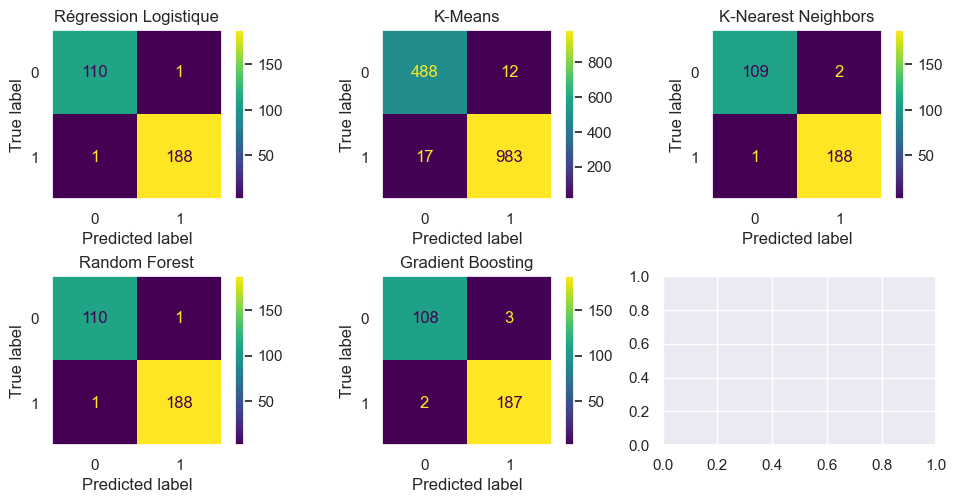

In [82]:
# Matrices de confusion
fig, ax = plt.subplots(2, 3, figsize=(10,5))

for i in range(2):
    for j in range(3):
        if 3*i+j == 5:
            break
        disp = ConfusionMatrixDisplay(confusion_matrix=cms[3*i+j], display_labels=[0, 1])
        disp.plot(ax=ax[i,j])
        ax[i,j].grid(None)
        ax[i,j].set_title(modeles[3*i+j])

fig.tight_layout(pad=0.5)
plt.show()

In [81]:
metriques = pd.DataFrame(
    {
        'Modèles' : modeles,
        'Accuracy' : acc,
        'Precision' : prec,
        'Recall': rec
    },
    columns=['Modèles', 'Accuracy', 'Precision', 'Recall']
)
metriques

,Modèles,Accuracy,Precision,Recall
0,Régression Logistique,0.993333,0.994709,0.994709
1,K-Means,0.980667,0.987940,0.983000
2,K-Nearest Neighbors,0.990000,0.989474,0.994709
3,Random Forest,0.993333,0.994709,0.994709
4,Gradient Boosting,0.983333,0.984211,0.989418
